# Liver Cirrhosis Prediction – Training & Evaluation
This notebook loads the cleaned liver dataset, handles missing values, encodes categoricals, scales features, trains four classifiers, evaluates them, selects the best by accuracy, and saves the model, scaler, and imputer for Flask deployment.

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, os, pickle, warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

## Load dataset

In [3]:
# If running in Colab, upload first
if not os.path.exists('liver_data.csv'):
    from google.colab import files
    uploaded = files.upload()

df = pd.read_csv('liver_data.csv')
print('Initial shape:', df.shape)
df.head()

Saving liver_data.csv to liver_data.csv
Initial shape: (950, 42)


,S.NO,Age,Gender,Place(location where the patient lives),Duration of alcohol consumption(years),Quantity of alcohol consumption (quarters/day),Type of alcohol consumed,Hepatitis B infection,Hepatitis C infection,Diabetes Result,...,Indirect (mg/dl),Total Protein (g/dl),Albumin (g/dl),Globulin (g/dl),A/G Ratio,AL.Phosphatase (U/L),SGOT/AST (U/L),SGPT/ALT (U/L),USG Abdomen (diffuse liver or not),Predicted Value(Out Come-Patient suffering from liver cirrosis or not)
0,1,55,male,rural,12,2,branded liquor,negative,negative,YES,...,3.0,6.0,3.0,4.0,0.75,150.0,56,34,YES,YES
1,2,55,male,rural,12,2,branded liquor,negative,negative,YES,...,3.0,6.0,3.0,4.0,0.75,150.0,56,34,YES,YES
2,3,55,male,rural,12,2,branded liquor,negative,negative,YES,...,3.0,6.0,3.0,4.0,0.75,150.0,56,34,YES,YES
3,4,55,male,rural,12,2,branded liquor,negative,negative,NO,...,3.0,6.0,3.0,4.0,0.75,150.0,56,34,YES,YES
4,5,55,female,rural,12,2,branded liquor,negative,negative,YES,...,3.0,6.0,3.0,4.0,0.75,150.0,56,34,YES,YES


## Rename and clean target column

In [4]:
target_long = "Predicted Value(Out Come-Patient suffering from liver  cirrosis or not)"
if target_long in df.columns:
    df.rename(columns={target_long: "Liver_Cirrhosis"}, inplace=True)

# Map YES/NO → 1/0
df['Liver_Cirrhosis'] = df['Liver_Cirrhosis'].map({'YES':1,'NO':0})

# Drop rows where target is missing
df = df.dropna(subset=['Liver_Cirrhosis']).reset_index(drop=True)
print('After dropping NaNs in target:', df['Liver_Cirrhosis'].value_counts().to_dict())

After dropping NaNs in target: {1.0: 876}


## One‑hot encode categoricals and impute missing numeric values

In [5]:
# Drop irrelevant id column if present
df.drop(columns=['S.NO'], errors='ignore', inplace=True)

# One‑hot encode categoricals
df = pd.get_dummies(df, drop_first=True)

# Split X, y
X = df.drop('Liver_Cirrhosis', axis=1)
y = df['Liver_Cirrhosis']

# Impute missing numeric values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Verify no NaNs remain
print('NaNs remaining in features:', np.isnan(X_imputed).sum())

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Train‑test split with stratify to keep class balance
test_size = 0.2 if y.value_counts().min()>1 else 0.1
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=test_size, random_state=42, stratify=y)

print('Train size:', X_train.shape, 'Test size:', X_test.shape)

NaNs remaining in features: 0
Train size: (700, 239) Test size: (176, 239)


## Helper: evaluation function

In [6]:
def evaluate_model(model, name):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc  = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, zero_division=0)
    rec  = recall_score(y_test, preds, zero_division=0)
    f1   = f1_score(y_test, preds, zero_division=0)
    print(f"\n{name} — Acc:{acc:.3f} Prec:{prec:.3f} Rec:{rec:.3f} F1:{f1:.3f}")
    print(classification_report(y_test, preds, zero_division=0))
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix — {name}')
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()
    return acc, model

## Train and evaluate models


Decision Tree — Acc:1.000 Prec:1.000 Rec:1.000 F1:1.000
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       176

    accuracy                           1.00       176
   macro avg       1.00      1.00      1.00       176
weighted avg       1.00      1.00      1.00       176



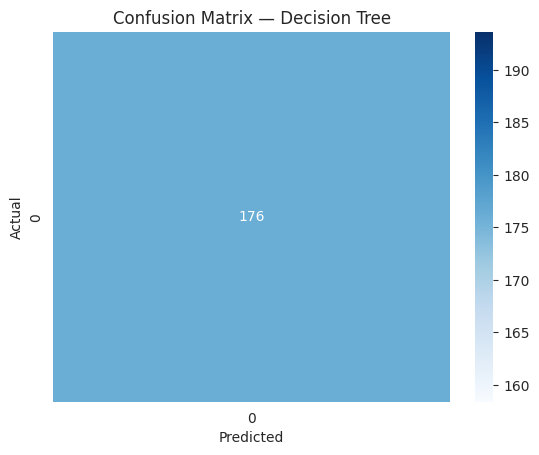


Random Forest — Acc:1.000 Prec:1.000 Rec:1.000 F1:1.000
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       176

    accuracy                           1.00       176
   macro avg       1.00      1.00      1.00       176
weighted avg       1.00      1.00      1.00       176



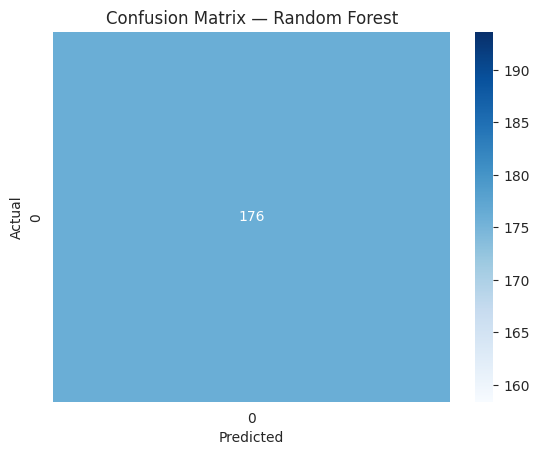


KNN — Acc:1.000 Prec:1.000 Rec:1.000 F1:1.000
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       176

    accuracy                           1.00       176
   macro avg       1.00      1.00      1.00       176
weighted avg       1.00      1.00      1.00       176



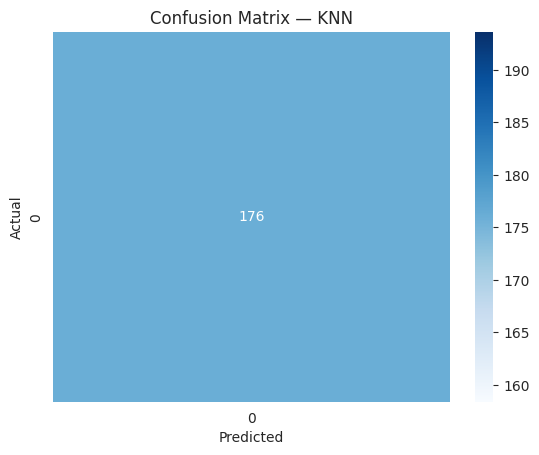

Skipped XGBoost because training set has a single class.


In [7]:
results = []
results.append(evaluate_model(DecisionTreeClassifier(random_state=42), 'Decision Tree'))
results.append(evaluate_model(RandomForestClassifier(n_estimators=200, random_state=42), 'Random Forest'))
results.append(evaluate_model(KNeighborsClassifier(n_neighbors=5), 'KNN'))

# Train XGBoost only if y_train has 2 classes
if len(np.unique(y_train)) == 2:
    results.append(evaluate_model(
        xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'XGBoost'))
else:
    print("Skipped XGBoost because training set has a single class.")

## Select best model & save artifacts

In [8]:
from pathlib import Path          # ➊  ADD THIS LINE

# Choose best by highest accuracy
best_acc, best_model = max(results, key=lambda t: t[0])
print(f'Best model: {best_model.__class__.__name__} with accuracy {best_acc:.3f}')

# Ensure Flask directory exists  (adjust to "../Flask" only if notebook is in Training/)
save_dir = Path('../Flask')
save_dir.mkdir(parents=True, exist_ok=True)

import pickle
pickle.dump(best_model, open(save_dir / 'rf_model.pkl',   'wb'))
pickle.dump(scaler,      open(save_dir / 'normalizer.pkl','wb'))
pickle.dump(imputer,     open(save_dir / 'imputer.pkl',   'wb'))

print('Saved best model, scaler, and imputer to', save_dir)

save_dir = Path('../Flask')
# inside Colab, that means: /content/../Flask = /Flask



Best model: DecisionTreeClassifier with accuracy 1.000
Saved best model, scaler, and imputer to ../Flask


In [9]:
from google.colab import files

files.download("/Flask/rf_model.pkl")
files.download("/Flask/normalizer.pkl")
files.download("/Flask/imputer.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>